In [1]:
import pandas as pd
from pathlib import Path

# Notebook location
NOTEBOOK_DIR = Path.cwd()

# Go UP two levels → "deep learning"
BASE_DIR = NOTEBOOK_DIR.parents[1]

GLOBAL_DATA = BASE_DIR / "data"
UTK_FACE_DATA_PATH = GLOBAL_DATA / "data-global" / "UTKFace"
print(UTK_FACE_DATA_PATH)

image_roots = []
ages = []

images_ext = ["png", "jpg", "peng"]
    
for image_file in UTK_FACE_DATA_PATH.iterdir():
    file_extension = image_file.name.split(".")[-1].lower()

    if file_extension not in images_ext:
        print(f"Skipping mal file type: {image_file.name}")
        continue
    if not image_file.is_file():
        continue

    parts = image_file.name.split("_")

    image_roots.append(image_file.name)
    ages.append(int(parts[0]))

dataset = pd.DataFrame({
    'image root': image_roots,
    'age': ages
})

dataset.head()

/home/hassan/Desktop/age-prediction/deeplearning/data/data-global/UTKFace
Skipping mal file type: 1_0_4_jdjdkdkdkd.txt
Skipping mal file type: 1_0_4_hdjd.txt


,image root,age
0,58_0_0_20170120134510215.jpg.chip.jpg,58
1,28_1_0_20170117022353982.jpg.chip.jpg,28
2,24_1_4_20161223231327524.jpg.chip.jpg,24
3,1_1_2_20161219222144951.jpg.chip.jpg,1
4,26_1_2_20170116184709433.jpg.chip.jpg,26


In [2]:
dataset['full_path'] = dataset['image root'].apply(lambda x: UTK_FACE_DATA_PATH / x)
dataset['full_path'] = dataset['full_path'].astype(str)
dataset.head()

,image root,age,full_path
0,58_0_0_20170120134510215.jpg.chip.jpg,58,/home/hassan/Desktop/age-prediction/deeplearni...
1,28_1_0_20170117022353982.jpg.chip.jpg,28,/home/hassan/Desktop/age-prediction/deeplearni...
2,24_1_4_20161223231327524.jpg.chip.jpg,24,/home/hassan/Desktop/age-prediction/deeplearni...
3,1_1_2_20161219222144951.jpg.chip.jpg,1,/home/hassan/Desktop/age-prediction/deeplearni...
4,26_1_2_20170116184709433.jpg.chip.jpg,26,/home/hassan/Desktop/age-prediction/deeplearni...


In [3]:
len(dataset)

23708

In [4]:
dataset["age"].dtype

dtype('int64')

In [5]:
dataset["full_path"].dtype

dtype('O')

In [6]:
dataset.to_csv("../../data/images_name_age_dataset.csv", index=False)


## Split data to train and test

In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train data length: ", len(train_df))
print("Test data length: " , len(test_df))

Train data length:  18966
Test data length:  4742


## Create a function to load and process images

In [13]:
import tensorflow as tf
IMG_SIZE = 200

def load_image(path, age):
    # Read and decode image (works only for JPEG)
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)

    # Optional: enforce shape (UTFKFace images are not consistent)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))

    # Normalize
    img = tf.cast(img, tf.float32) / 255.0
    
    return img, tf.cast(age, tf.float32)


### Change pandas data frame to tensorflow dataset

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['full_path'].values, train_df['age'].values)
)

train_ds = (
    train_ds
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)


In [17]:
val_ds = tf.data.Dataset.from_tensor_slices(
    (test_df['full_path'].values, test_df['age'].values)
)

val_ds = (
    val_ds
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)


In [15]:
import os

for p in train_df['full_path'].head(10):
    if not os.path.exists(p):
        print("Missing file:", p)


In [16]:
for images, ages in train_ds.take(1):
    print(images.shape, ages[:10])


(32, 200, 200, 3) tf.Tensor([ 1. 36. 28. 75. 32. 25. 35. 65. 29. 45.], shape=(10,), dtype=float32)


2025-11-16 18:27:11.728180: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
for images, ages in val_ds.take(1):
    print(images.shape)
    print(ages.numpy())



(32, 200, 200, 3)
[88. 47. 17. 24. 20. 29. 58. 34. 15. 45. 26. 22.  6. 28. 57. 31. 45. 15.
  6. 55. 28. 27. 18.  2. 40. 26. 45.  2. 80. 54. 16.  4.]


2025-11-16 18:33:28.637954: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


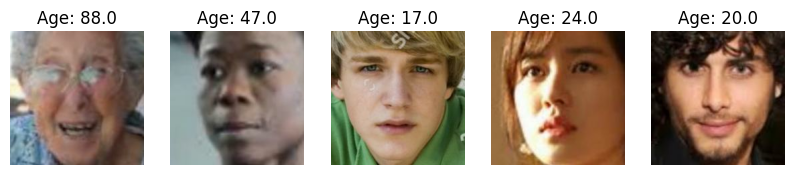

In [23]:
import matplotlib.pyplot as plt

for images, ages in val_ds.take(1):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(images[i].numpy())
        plt.title(f"Age: {ages[i].numpy()}")
        plt.axis("off")
    break


### CNN model for age prediction

In [24]:
from tensorflow.keras import layers, models

def build_model():
    model = models.Sequential([
        layers.Input(shape=(200, 200, 3)),
        
        layers.Conv2D(32, (3, 3), activation="relu"),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D(),
        
        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.MaxPooling2D(),
        
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(1) 
    ])
    
    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"]
    )
    
    return model

model = build_model()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,667,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,760,641 (33.42 MB)

 Trainable params: 8,760,641 (33.42 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the Model

In [25]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)


Epoch 1/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 146s 245ms/step - loss: 325.0327 - mae: 13.5716 - val_loss: 220.6860 - val_mae: 11.7751
Epoch 2/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 157s 265ms/step - loss: 160.1397 - mae: 9.4761 - val_loss: 134.4167 - val_mae: 8.7015
Epoch 3/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 163s 274ms/step - loss: 113.2806 - mae: 7.9131 - val_loss: 105.8971 - val_mae: 7.4914
Epoch 4/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 159s 268ms/step - loss: 90.2081 - mae: 7.0508 - val_loss: 98.0094 - val_mae: 7.1758
Epoch 5/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 159s 267ms/step - loss: 78.3461 - mae: 6.5864 - val_loss: 108.2637 - val_mae: 7.4503
Epoch 6/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 160s 269ms/step - loss: 63.6315 - mae: 5.9740 - val_loss: 92.7556 - val_mae: 7.1217
Epoch 7/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 157s 265ms/step - loss: 54.7859 - mae: 5.5483 - val_loss: 89.2500 - val_mae: 6.9502
Epoch 8/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 147s 248ms/step - loss: 47.0134 - mae: 5.1370 - val_loss: 90.1552 - val_mae: 6.9344

In [26]:
scores = model.evaluate(val_ds)

149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 89.2174 - mae: 6.7868


In [27]:
model.save('../../models/age_detection_model.keras')